In [1]:
%cd ..
!date

/sunjinsheng/codebase/cv_codeformer
Mon Aug  5 06:40:59 CST 2024


In [2]:
import os
import cv2
import argparse
import glob
import torch
from PIL import Image
from torchvision.transforms.functional import normalize
from torchvision import transforms

from src.utils import imwrite, img2tensor, tensor2img
from src.utils.download_util import load_file_from_url
from src.utils.misc import get_device
from src.archs import * # !register architectures
from src.utils.options import dict2str
from src.utils.registry import ARCH_REGISTRY

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------ set up CodeFormer restorer -------------------
net = ARCH_REGISTRY.get('VQAutoEncoder')(
    img_size=512,
    nf=64,
    ch_mult=[1,2,2,4,4,8],
    quantizer='nearest',
    codebook_size=512,
).to(device)

In [4]:
ckpt_path = 'experiments/20240731_115629_VQGAN-512-ds32-nearest-stage1/models/net_g_80000.pth'
checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=True)['params_ema']
net.load_state_dict(checkpoint)
net.eval()
# print(net.state_dict().keys())
set([key.split('.')[0] for key in list(net.state_dict().keys())])

{'encoder', 'generator', 'quantize'}

Processing: a0037.jpg


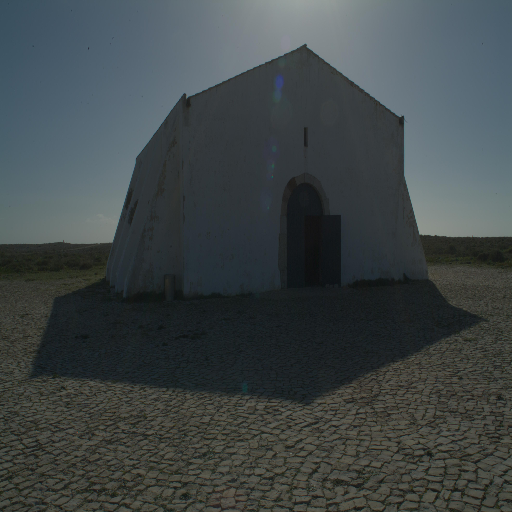

In [5]:
# -------------------- start to processing ---------------------
suffix = '.jpg'
result_root = 'results'
img_path = 'data/iharmony4/HAdobe5k/real_images/a0037.jpg'

img_name = os.path.basename(img_path)
basename, ext = os.path.splitext(img_name)
print(f'Processing: {img_name}')
input_face = cv2.imread(img_path)
input_face = cv2.cvtColor(input_face, cv2.COLOR_BGR2RGB)
input_face = cv2.resize(input_face, (512, 512))
assert input_face.shape[:2] == (512, 512), 'Input resolution must be 512x512 for inpainting.'
Image.fromarray(input_face)

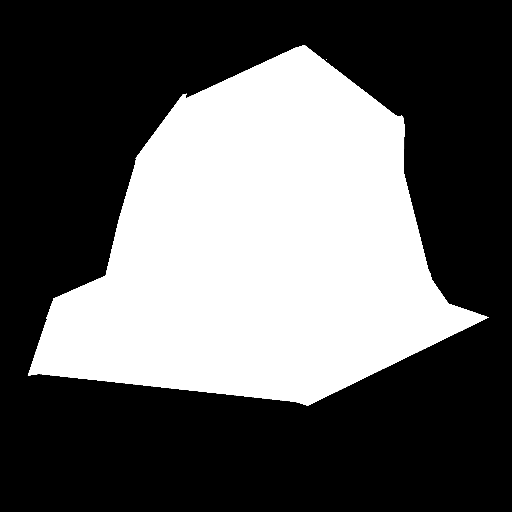

In [6]:
mask_path = "/root/wp/data/iharmony4/HAdobe5k/masks/a0037_1.png"
mask = cv2.imread(mask_path, 0)
mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_LINEAR)
Image.fromarray(mask)

In [7]:
# input_face = cv2.resize(input_face, (512, 512), interpolation=cv2.INTER_LINEAR)
input_face = img2tensor(input_face / 255., bgr2rgb=True, float32=True)
normalize(input_face, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)
input_face = input_face.unsqueeze(0).to(device)

tf = transforms.Compose([
    transforms.ToTensor(),
])
mask = tf(mask)
mask = mask.view(1, 1, 512, 512).to(device)

In [8]:
with torch.no_grad():
    # w is fixed to 1, adain=False for inpainting
    x = net.encoder(input_face)
    quant, codebook_loss, quant_stats = net.quantize(x)
    output = net.generator(quant)

    # output, cb_loss, quan_index = net(input_face)


# del output_face
# torch.cuda.empty_cache()

In [9]:
x.shape, quant.shape, output.shape 

(torch.Size([1, 256, 16, 16]),
 torch.Size([1, 256, 16, 16]),
 torch.Size([1, 3, 512, 512]))

In [10]:
mask.device

device(type='cuda', index=0)

In [11]:
output = (1-mask)*input_face + mask*output
saved = tensor2img(output, rgb2bgr=True, min_max=(-1, 1))

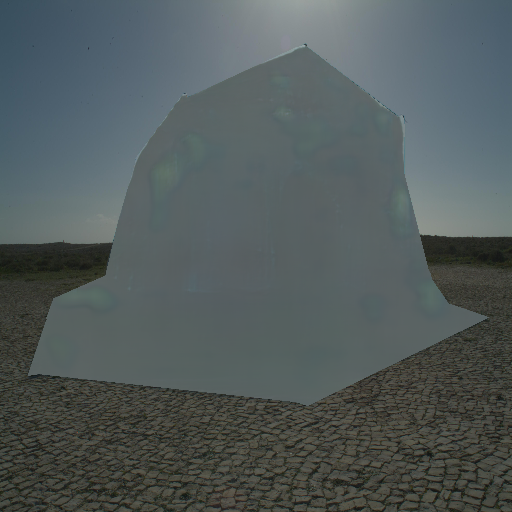

In [12]:
saved = saved.astype('uint8')
Image.fromarray(saved)